In [17]:
# Importando Bibliotecas necessarias
import numpy as np 
import pandas as pd

In [18]:
# Instalando Duck Duck Go
!pip install -Uqq duckduckgo_search

In [19]:

# Importando Funções das Bibliotecas
from duckduckgo_search import ddg_images
from fastai.vision.all import *

# Definição da Função de Busca do Duck Duck Go
def search_images(term, max_images=300): return L(ddg_images(term, max_results=max_images)).itemgot('image')
     

---

# Objetivo:
Este artigo tem como objetivo analisar de forma abrangente o funcionamento de uma CNN (Rede Neural Convolucional). Iniciaremos definindo o conceito de convolução, usando representações visuais que não apenas irão esclarecer o processo em si, mas também irão destacar sua relevância para classificação de imagens. Depois, falaremos sobre a arquitetura de uma rede neural, explorando como as convoluções são importantes para seu aprendizado na tarefa de reconhecimento de padrões em imagens.

---

## Dowload das Imagens

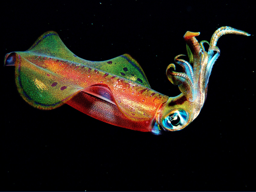

In [20]:
# Carregar o primeiro resultado de Lula da pesquisa
urls = search_images('Squid photos', max_images=1)

from fastdownload import download_url
dest = 'Squid.jpg'
download_url(urls[0], dest, show_progress=False)
im = Image.open(dest)
im.to_thumb(256,256)

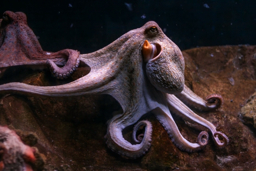

In [21]:
# Carregar o Primeiro Resultado de Polvo da pesquisa
urls = search_images('Octopus photos', max_images=1)

dest = 'Octopus.jpg'
download_url(urls[0], dest, show_progress=False)
im = Image.open(dest)
im.to_thumb(256,256)

In [22]:
# Define searches for 'Squid' and 'Octopus'
searches = 'Squid', 'Octopus'
path = Path('Squidward?')

from time import sleep

# Download e resize das imagens
for o in searches:
    dest = (path/o)
    dest.mkdir(exist_ok=True, parents=True)
    download_images(dest, urls=search_images(f'{o}'))
    sleep(1)  # Pause between searches to avoid over-loading server
    resize_images(path/o, max_size=400, dest=path/o)

In [23]:
# Remove imagens falhas
failed = verify_images(get_image_files(path))
failed.map(Path.unlink)
len(failed)

12

In [24]:
import os
import glob

# Contar imagens em cada pasta para verificar possível tendencia nos testes
def count_images(folder_path):
    if not os.path.exists(folder_path):
        print(f"The specified folder path '{folder_path}' does not exist.")
        return

    jpg_files = glob.glob(os.path.join(folder_path, '*.jpg'))

    num_jpg_images = len(jpg_files)

    return num_jpg_images

root_folder_path = '/kaggle/working/Squidward?/'
folder_image_counts = []
folders = []

for folder in os.listdir(root_folder_path):
    folders.append(folder)
    folder_image_counts.append(count_images(f'{root_folder_path}/{folder}'))

for folder, count in zip(folders, folder_image_counts):
    print(f"Folder: {folder}, Image Count: {count}")


Folder: Squid, Image Count: 146
Folder: Octopus, Image Count: 160


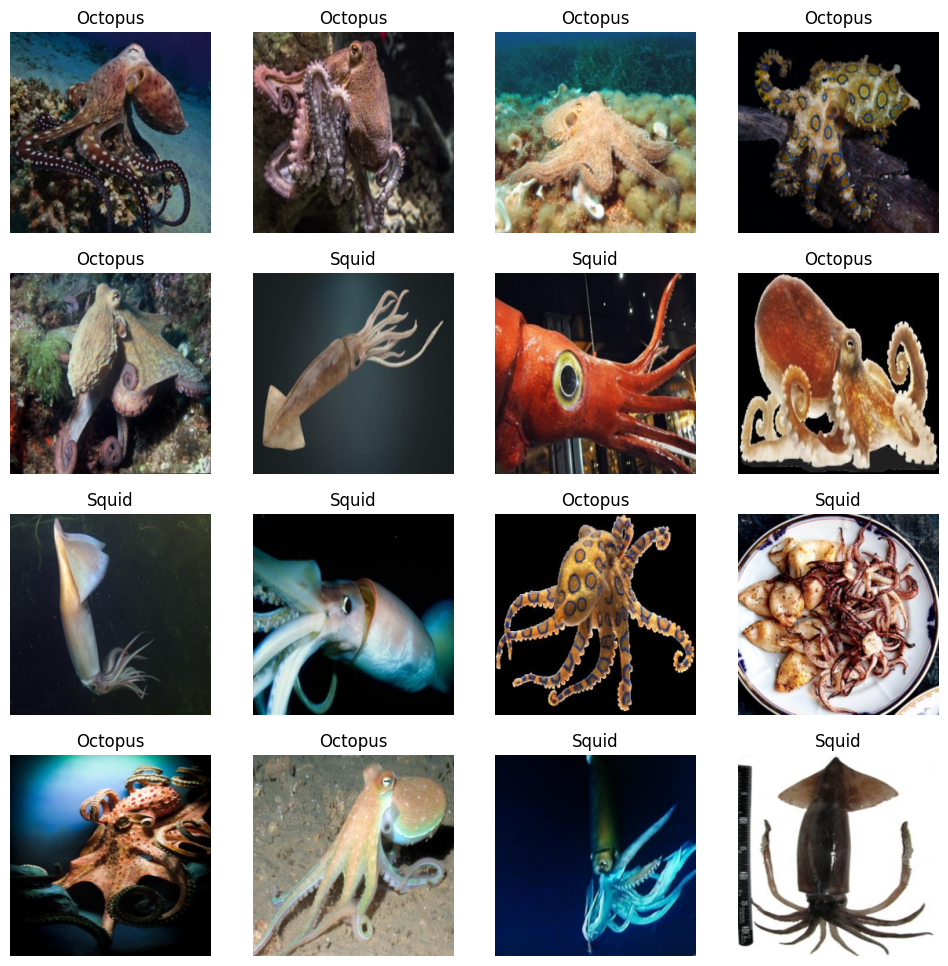

In [25]:
dls = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=[Resize(256, method='squish')]
).dataloaders(path, bs=32)

dls.show_batch(max_n=16)

In [26]:
# Abrir e mudar tamanho de imagem para exemplo de convolução
im = Image.open(r'/kaggle/working/Squid.jpg')
newsize = (50, 50)
im2 = im.resize(newsize)

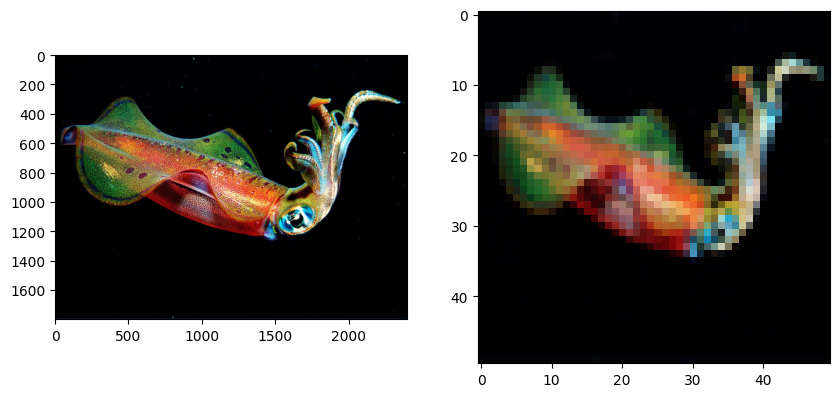

In [27]:
from matplotlib import pyplot as plt
img = np.asarray(im2)
# Converter imagem para array NumPy
original = np.asarray(im, dtype=np.uint8)
fig, axs = plt.subplots(1, 2, figsize=(10,5))
axs[0].imshow(original)
axs[1].imshow(img)

---

Acima, foi pego uma imagem do dataset com a qual vamos trabalhar.

Essa imagem então foi transformada num array de 50 por 50 por 3, sendo 50 por 50 sua resolução e o 3 para compor os 3 canais de RGB, formando as cores. Por exemplo, o RGB do pixeis ao redor do 16 x 16:

In [28]:
plot = {}
for y in range(3):
    for x in range(3):
        value_x = 15+x
        value_y = 15+y
        plot[f'{value_x}:{value_y}'] = img[value_x][value_y]

plot

{'15:15': array([ 98, 130,  96], dtype=uint8),
 '16:15': array([114, 143, 116], dtype=uint8),
 '17:15': array([126,  95,  77], dtype=uint8),
 '15:16': array([55, 78, 79], dtype=uint8),
 '16:16': array([108, 139, 118], dtype=uint8),
 '17:16': array([108, 106,  88], dtype=uint8),
 '15:17': array([20, 33, 40], dtype=uint8),
 '16:17': array([ 99, 128, 123], dtype=uint8),
 '17:17': array([100, 115, 103], dtype=uint8)}

In [29]:
# Criar filtro de convolução manualmente
filter_1 = np.zeros((3,3,3), dtype=float)

filter_1[0][0][0] = 0.8
filter_1[0][0][1] = 0.2
filter_1[0][0][2] = 0.8

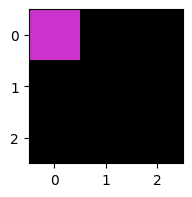

In [30]:
# Mostrar o Filtro comparado ao normal
fig, ax = plt.subplots(1, 1, figsize=(2,2))
ax.imshow(filter_1)

---

Acima, observa-se uma matriz 3 por 3, com apenas o valor do meio diferente de zero (representado por cores), onde as areas pretas simbolizam valor zero na matriz. Essa matriz representa um filtro, ou kernel, com o qual se utiliza nas convoluções para alterar as imagens. A imagem resultante da convolução da lula original (a imagem abaixo da esquerda), por esse filtro é vista abaixo (a imagem da direita).

In [52]:
# Perform convolution manually on the image
img_2 = np.zeros((50,50,3), dtype=float)

for i in range(50):
    for j in range(50):
        img_2[i][j][0] = img[:,:,0][i][j] * 0.8
        img_2[i][j][1] = img[:,:,1][i][j] * 0.2
        img_2[i][j][2] = img[:,:,2][i][j] * 0.8

img_2 = np.asarray(img_2, dtype=np.uint8)
np.shape(img_2)

(50, 50, 3)

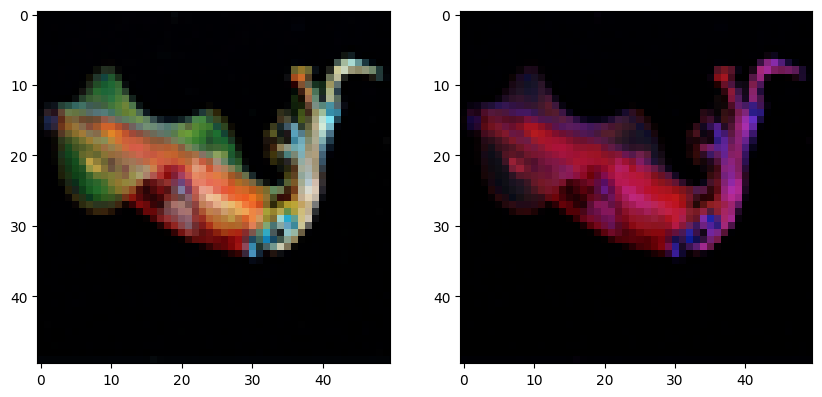

In [53]:
# Display the original image and the result of convolution
fig, axs = plt.subplots(1, 2, figsize=(10,5))
axs[0].imshow(img)
axs[1].imshow(img_2)

---
### Dropout

In [33]:
def show_img(img, title="Image"):
    plt.imshow(img)
    plt.title(title)
    plt.axis('off')
    plt.show()

In [34]:
def dropout_np(img, factor=0.5):
    random_tensor = np.random.rand(*img.shape)
    dropout_mask = (random_tensor > factor).astype(np.uint8)
    return img * dropout_mask

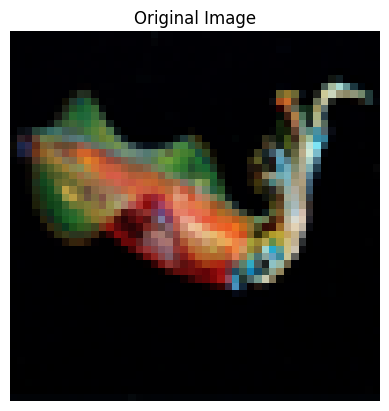

In [35]:
show_img(img, title="Original Image")

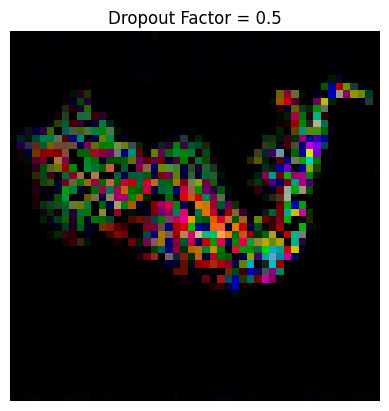

In [36]:
dropped_img = dropout_np(img)
show_img(dropped_img, title="Dropout Factor = 0.5")

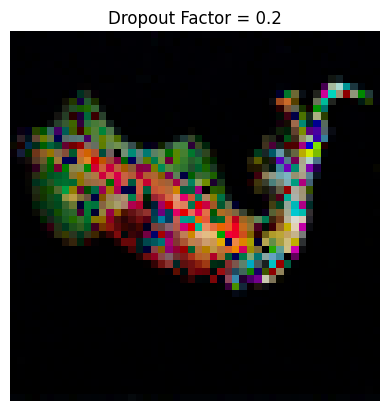

In [37]:
dropped_img = dropout_np(img, 0.2)
show_img(dropped_img, title="Dropout Factor = 0.2")

---
## Detecção de Bordas

Esse trecho irá demonstrar as funções de detecção de bordas na imagem em preto e branco, mostrando a detecção vertical e horizontal, além da composição das duas juntas

---

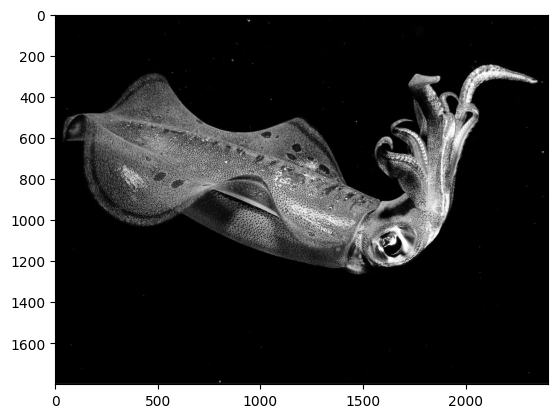

In [38]:
# Convert the image to black and white
img_bw = im.convert(mode='L')
img_bw = np.asarray(img_bw, dtype=np.uint8)
plt.imshow(img_bw, cmap='gray', vmin=0, vmax=255)

In [39]:
np.shape(img_bw)

(1800, 2400)

---
### Definindo Detecção de Bordas vertical e horizontal

In [40]:
from scipy import signal as sig

In [41]:
#Filtro de detecção de bordas horizontais
filter_2 = [-0.125, 0.0, 0.125],[-0.25, 0.0, 0.25],[-0.125, 0.0, 0.125]
filter_2 = np.asarray(filter_2)

In [42]:
#Filtro de detecção de bordas verticais
filter_3 = [-0.125, -0.25, -0.125],[0.0, 0.0, 0.0],[0.125, 0.25, 0.125]
filter_3 = np.asarray(filter_3)

#### Executando a convolução usando os filtros

In [43]:
img_4 = sig.fftconvolve(img_bw, filter_2, mode = 'same')
img_4 = np.asarray(img_4, dtype=np.uint8) / 1.25

In [44]:
img_5 = sig.fftconvolve(img_bw, filter_3, mode = 'same')
img_5 = np.asarray(img_5, dtype=np.uint8) / 1.25

# Combine the results of vertical and horizontal edge detection using the Sobel method
sobel = np.sqrt(np.square(img_4) + np.square(img_5)) / 1.25

---
Abaixo, temos os 2 exemplos de detecção de borda, da esquerda para a direita temos:
- Detecção de Bordas Verticais
- Detecção de Bordas orizontais
- Combinação pelo método de Sobel: $$G=\sqrt{G^2_x+G^2_y}$$

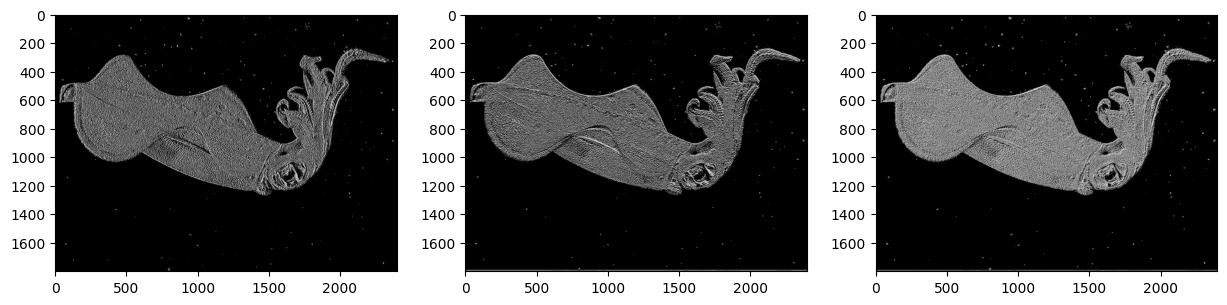

In [45]:
fig, axs = plt.subplots(1, 3, figsize=(15,5))
axs[0].imshow(img_4, cmap='gray', vmin=0, vmax=255)
axs[1].imshow(img_5, cmap='gray', vmin=0, vmax=255)
axs[2].imshow(sobel, cmap='gray', vmin=0, vmax=255)

## Modelos

### Resnet 50

In [46]:
learn = vision_learner(dls, resnet50)
learn.fine_tune(10)

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 157MB/s] 


epoch,train_loss,valid_loss,time
0,0.620559,0.167866,00:07


epoch,train_loss,valid_loss,time
0,0.036622,0.111861,00:03
1,0.025482,0.120364,00:02
2,0.024372,0.224976,00:02
3,0.022060,0.147846,00:02
4,0.019551,0.092030,00:02
5,0.015577,0.078464,00:02
6,0.013090,0.067082,00:02
7,0.010645,0.089678,00:02
8,0.010234,0.080782,00:02
9,0.008349,0.071903,00:02


### Modelo Manual

In [47]:
def conv(ni, nf, ks=3, act=True):
    res = nn.Conv2d(ni, nf, stride=2, kernel_size=ks, padding=ks//2)
    if act: res = nn.Sequential(res, nn.ReLU())
    return res

In [48]:
simple_cnn = sequential(
    conv(3 ,4),
    conv(4 ,8),
    conv(8 ,16),
    conv(16,32),
    conv(32,64),
    conv(64,2, act=False),
    Flatten(),
    nn.Dropout(0.2),
)

In [49]:
learn2 = Learner(dls, simple_cnn)

In [50]:
learn2.fine_tune(16)

epoch,train_loss,valid_loss,time
0,3.398616,3.123908,00:01


epoch,train_loss,valid_loss,time
0,3.032102,2.887169,00:01
1,2.860110,2.381001,00:01
2,2.609804,1.590679,00:01
3,2.341663,1.328585,00:01
4,2.192687,1.277629,00:01
5,2.085518,1.267342,00:01
6,2.020413,1.310310,00:01
7,1.960136,1.264389,00:01
8,1.897041,1.275921,00:01
9,1.857574,1.259532,00:01


Acima estão os filtros usados nas detecções de borda, vertical e horizontal respectivamente. Os zeros nos filtros estão representados por um azul-esverdeado, sendo valores negativos mais avermelhados e valores positivos mais amarelados.

---

## Export e deploy

In [51]:
learn.export('model.pkl')
learn2.export('learn.pkl')

Os modelos podem ser testados com imagens de exemplo no HuggingFace

[Modelo com Resnet 50](https://huggingface.co/spaces/AlGouvea/ML_Lesson8_Alvaro_Resnet50/blob/main/app.py)

[Modelo com CNN Simples](https://huggingface.co/spaces/AlGouvea/ML_Lesson8_Alvaro_ManualModel)